In [1]:
# Import required libraries
import pathlib
import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt

# Enable inline plotting for matplotlib
%matplotlib inline

# Define default arguments for saving figures
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}

# Set Matplotlib savefig DPI
mpl.rc("savefig", dpi=300)

# Define the output directory and make sure it exists
output_dir = "../../figures/asc_overview"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

# Define output file suffix and formats
output_suffix = ""
output_formats = [".png", ".pdf"]

# Function to save a figure in multiple formats
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix,
                output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(
            f"{output_dir}/{name}{output_suffix}{output_format}", **savefig_args
        )
    return None

# Set Scanpy figure parameters
sc.set_figure_params(
    dpi_save=150, frameon=False,
    vector_friendly=True, fontsize=6, figsize=(3, 3),
    format='pdf', transparent=True
)

# Configure pandas display options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

# Set Scanpy figure directory
sc.settings.figdir = output_dir

# Import helper functions
%run ../helper.py

# Set Seaborn style
sns.set_style("ticks")

# Use custom Matplotlib style
plt.style.use('../bursa.mplstyle')


## Load the Data

In [2]:
celltype_file = "ASC"
celltype = 'ASC'

In [3]:
adata = sc.read_h5ad(
    f"/home/michaelswift/repos/tabula-bursa/data/{celltype_file}.h5ad.gz")

# Calculate Initial Representation

In [4]:
sc.pp.neighbors(adata, use_rep="X_scVI_all", n_neighbors=20)
sc.tl.umap(
    adata,
    min_dist=0.3,
)
sc.tl.leiden(adata, resolution = 1, key_added='leiden')


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/michaelswift/miniconda3/envs/scanpy_new/li

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tool

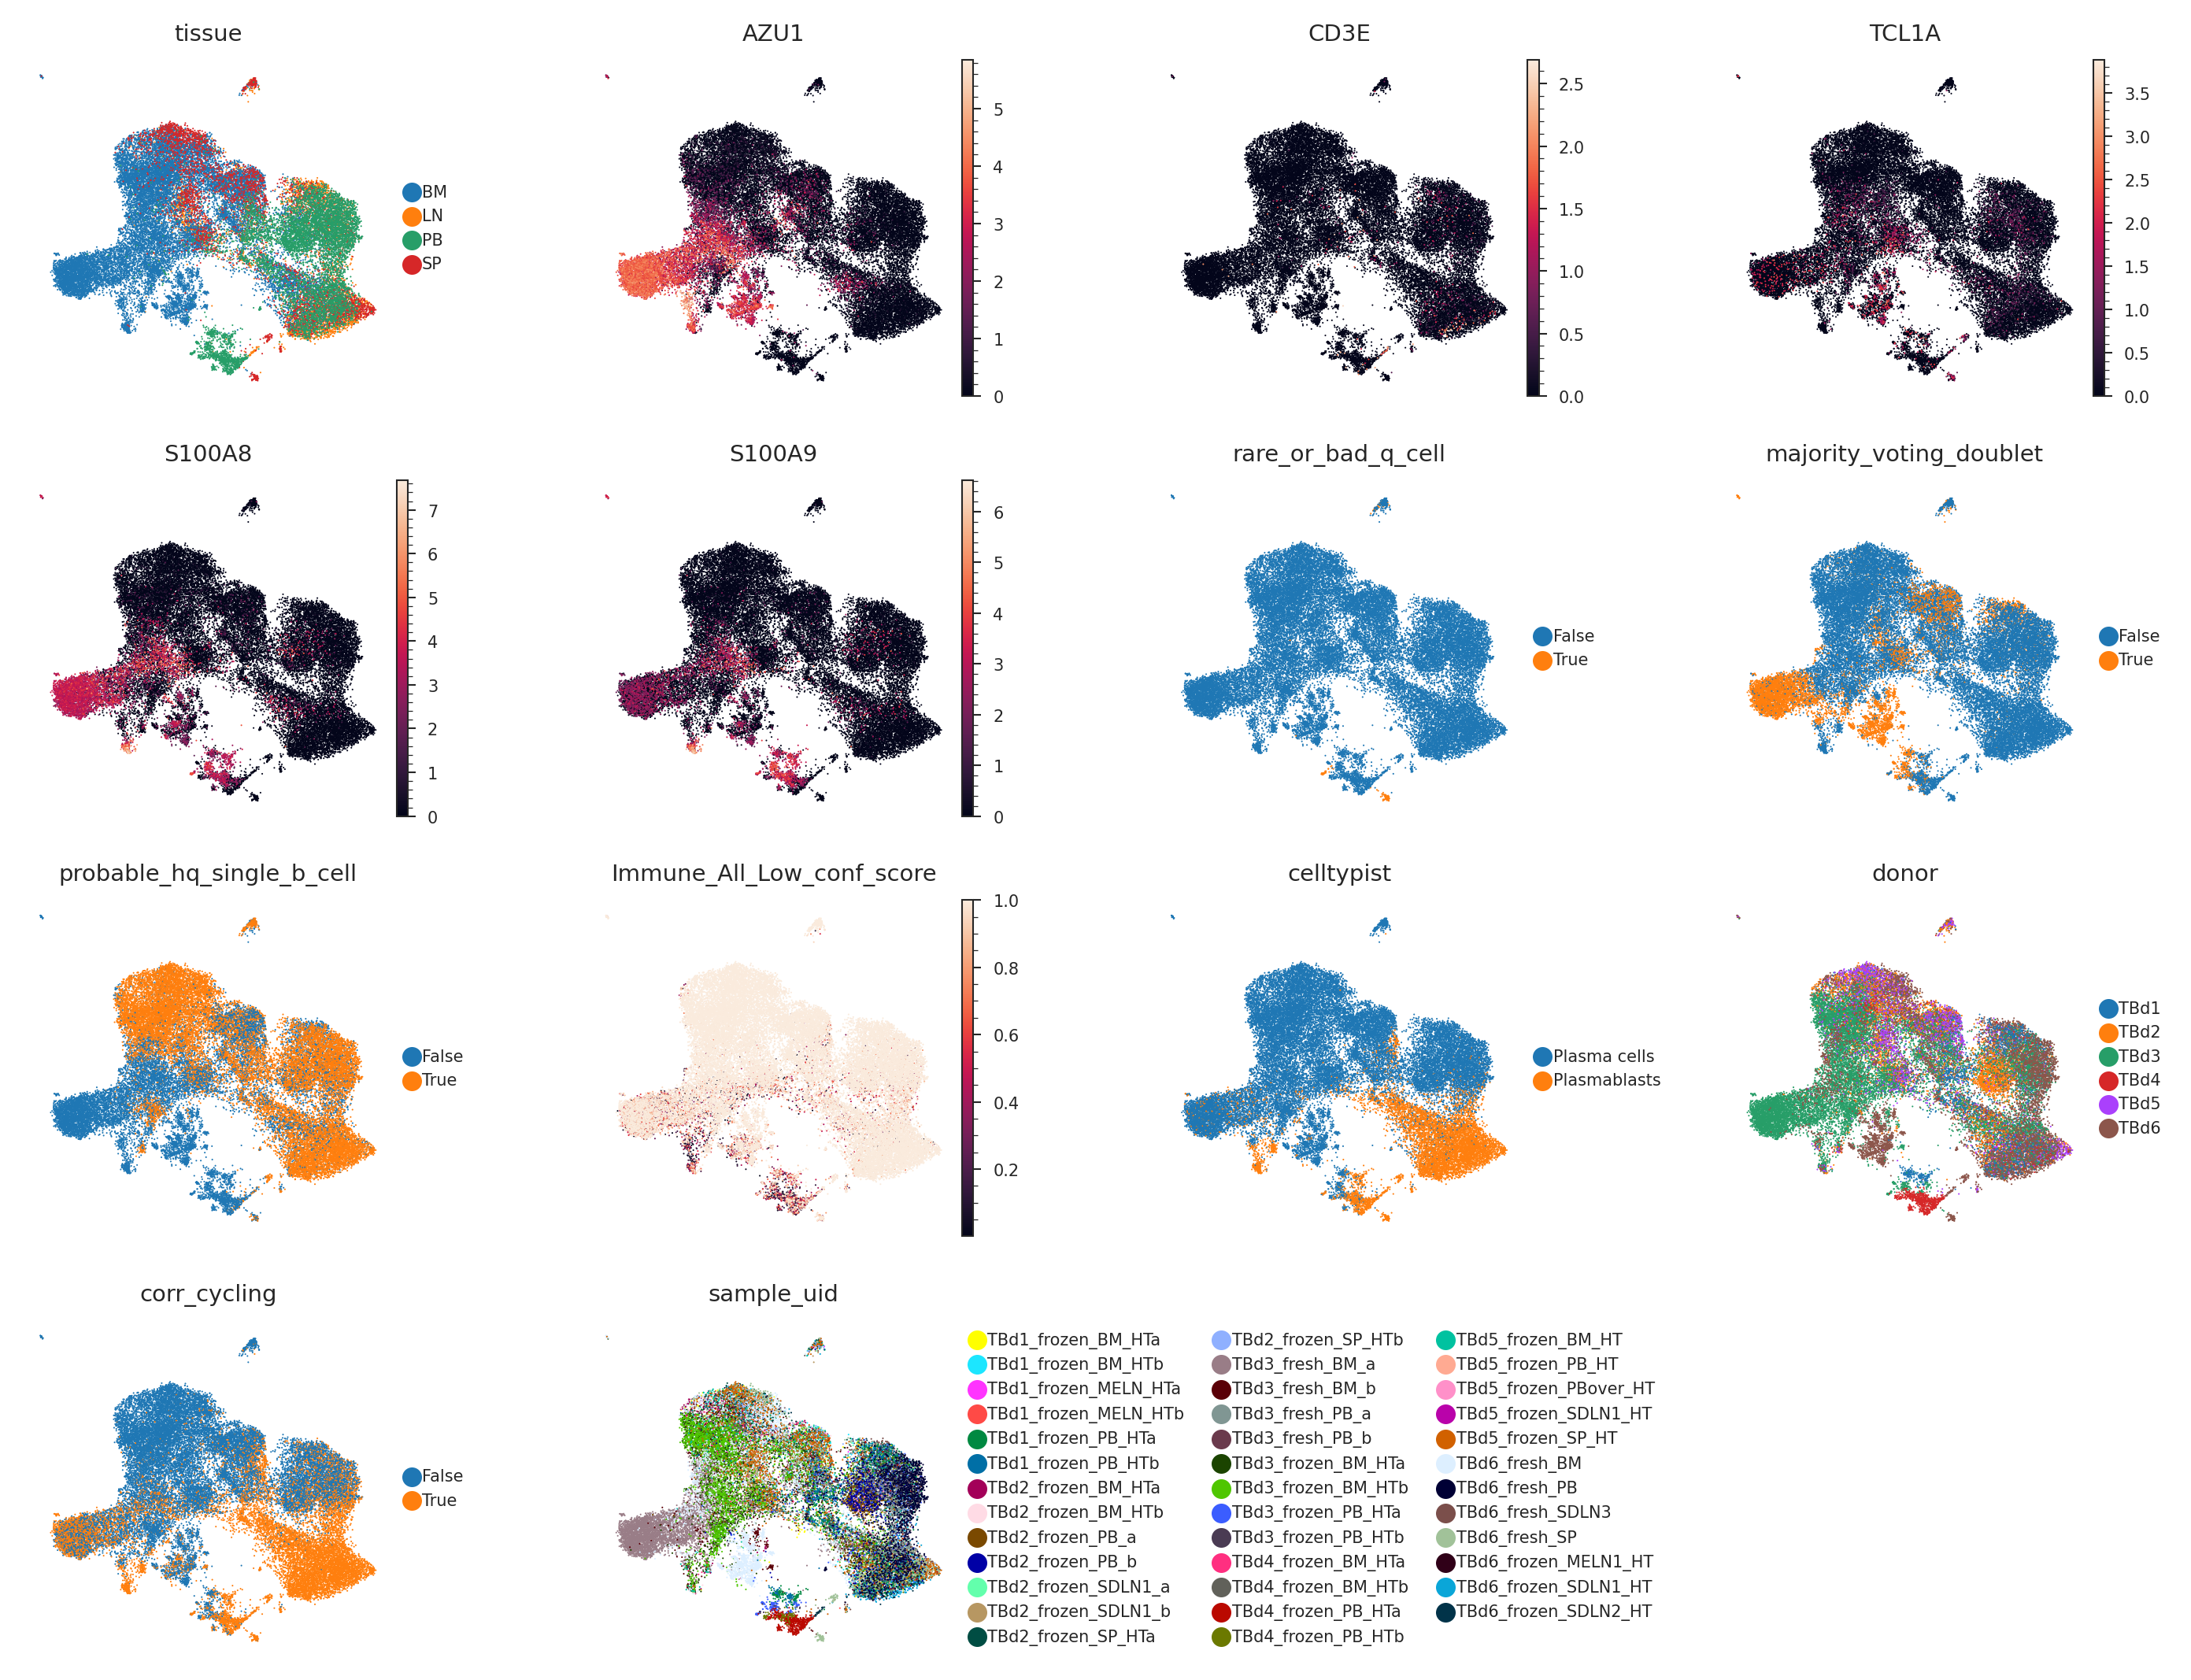

In [5]:
sc.pl.umap(adata, color = ['tissue', 'AZU1', 'CD3E', "TCL1A", "S100A8", "S100A9", 'rare_or_bad_q_cell', 
"majority_voting_doublet", 'probable_hq_single_b_cell', 
"Immune_All_Low_conf_score", 'celltypist', 'donor', 'corr_cycling', 'sample_uid', ], size = 1)

# remove contaminants and artifacts

In [6]:
# Subset to high quality single B cells
print(adata.shape[0], "possible B cells by celltypist labeling")
adata = adata[adata.obs.probable_hq_single_b_cell == 'True']
print(adata.shape[0], "hq single b cells via automatic flagging")

36955 possible B cells by celltypist labeling
21192 hq single b cells via automatic flagging


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


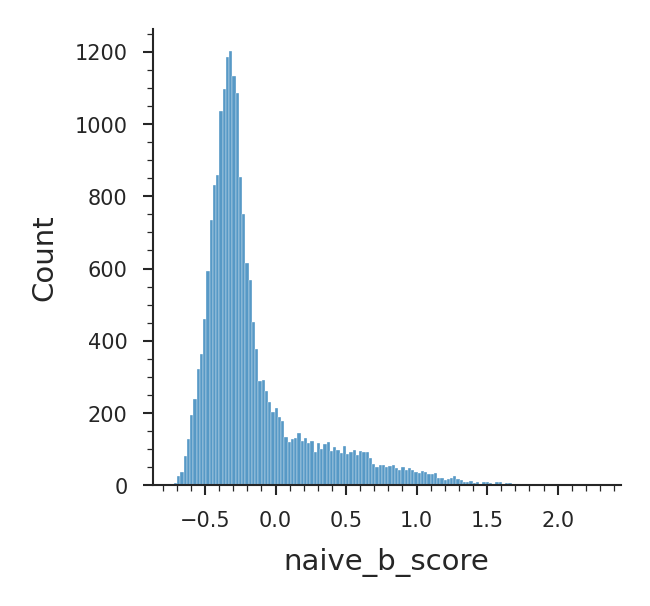

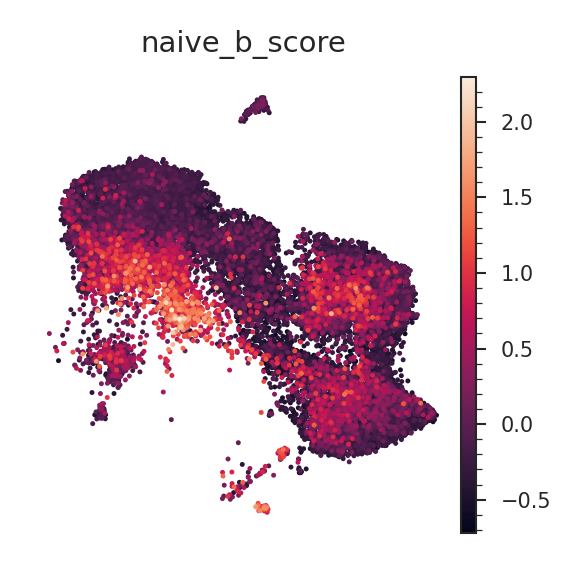

19284 ASCs after filtering out Naive ASC doublet signature
16024 ASCs after filtering out ASCs without a c_call (VDJ assembly)


In [7]:
# filter out known artefacts
sc.tl.score_genes(adata, gene_list = ['TCL1A', 'AFF3', "CD37", "BANK1"], score_name = "naive_b_score")
fig, ax = plt.subplots(1,1)
sns.histplot(data = adata.obs, x = 'naive_b_score', ax = ax)
sc.pl.umap(adata, color = 'naive_b_score')
# remove cells with high naive score
adata = adata[adata.obs.naive_b_score < 0.5]
print(adata.shape[0], "ASCs after filtering out Naive ASC doublet signature")
# remove cells without proper VDJ assemblies 
adata = adata[adata.obs.c_call.isin(IGH_switched().keys())]
print(adata.shape[0], "ASCs after filtering out ASCs without a c_call (VDJ assembly)")

# Calculate new representation on filtere dataset

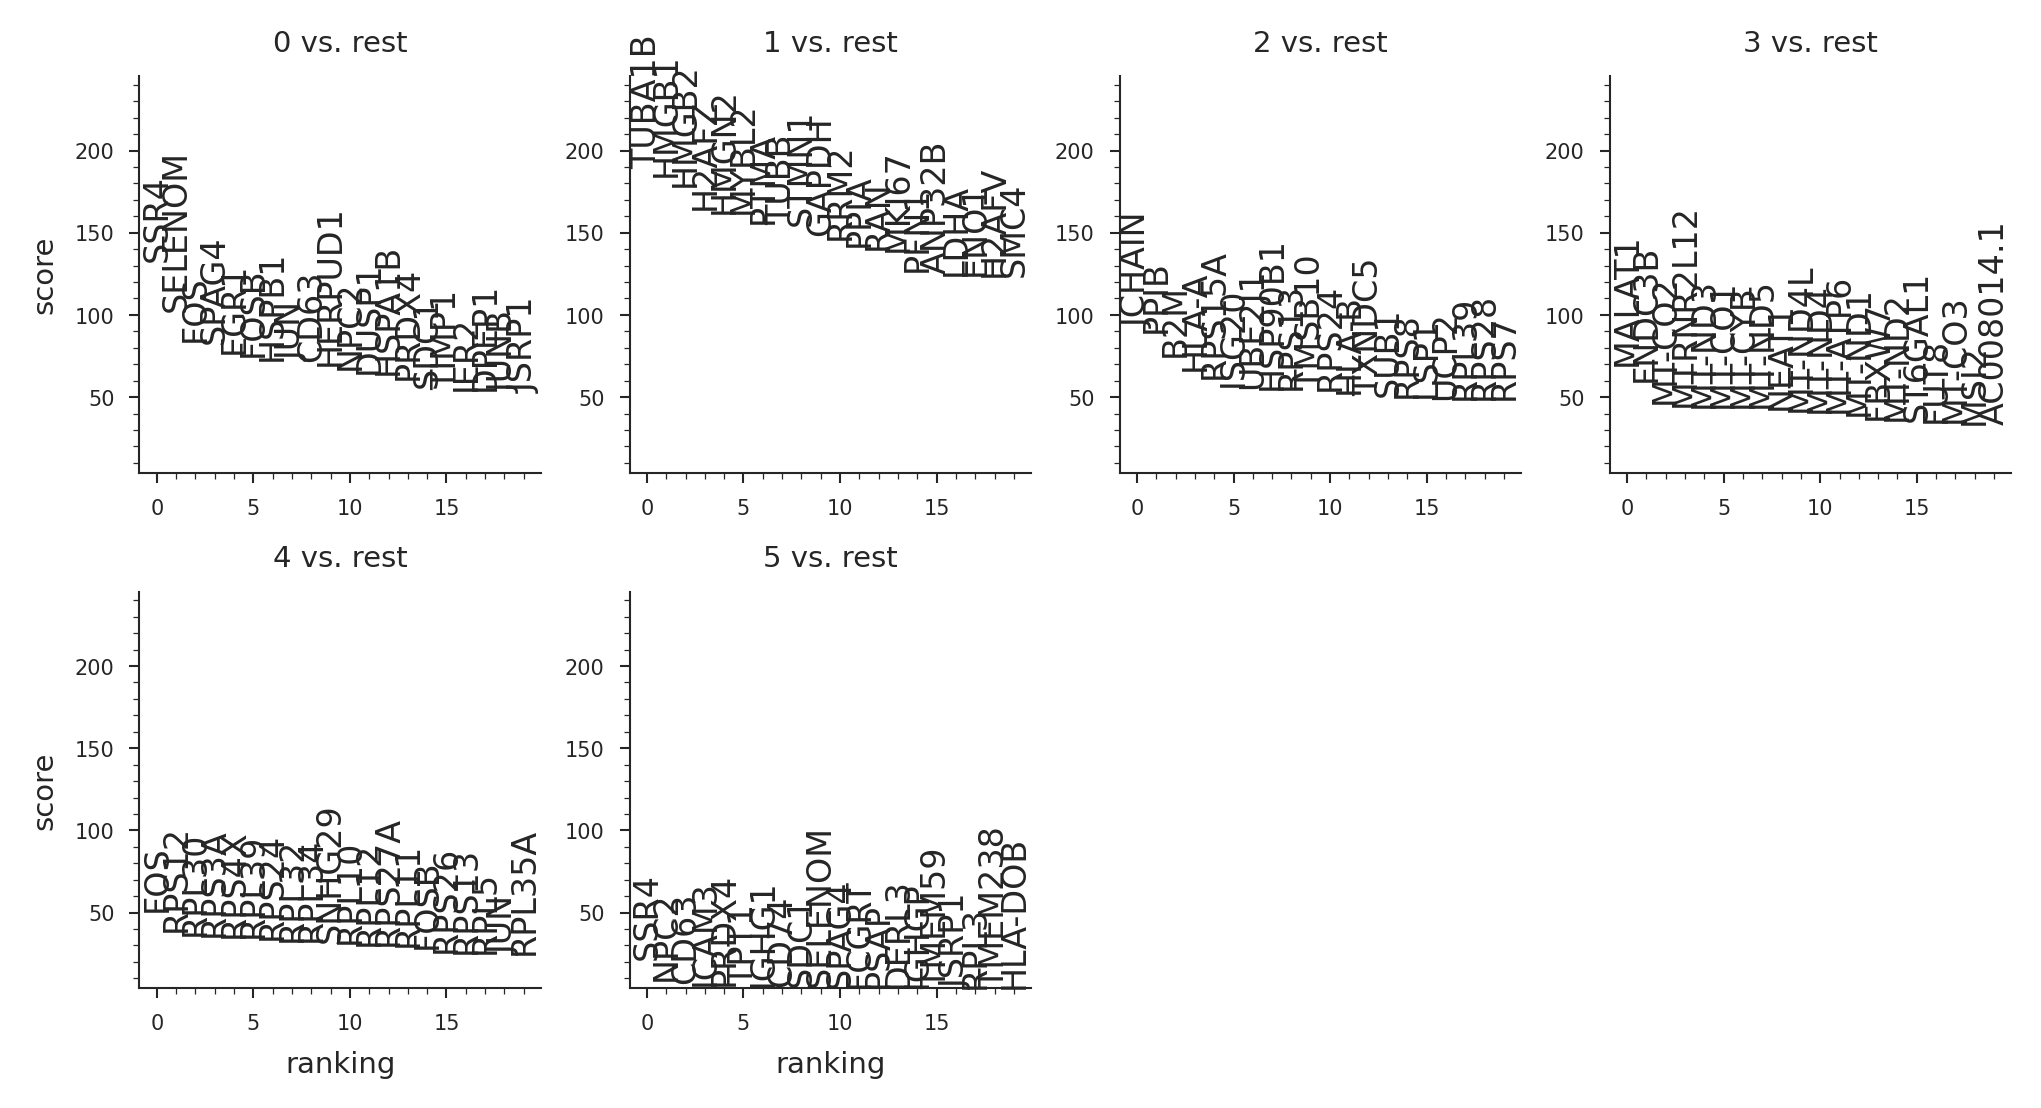

In [8]:
sc.pp.neighbors(adata, use_rep="X_scVI_all", n_neighbors=20)
sc.tl.umap(
    adata,
    min_dist=0.3,
)
sc.tl.leiden(adata, resolution=0.4)
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups(adata)

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


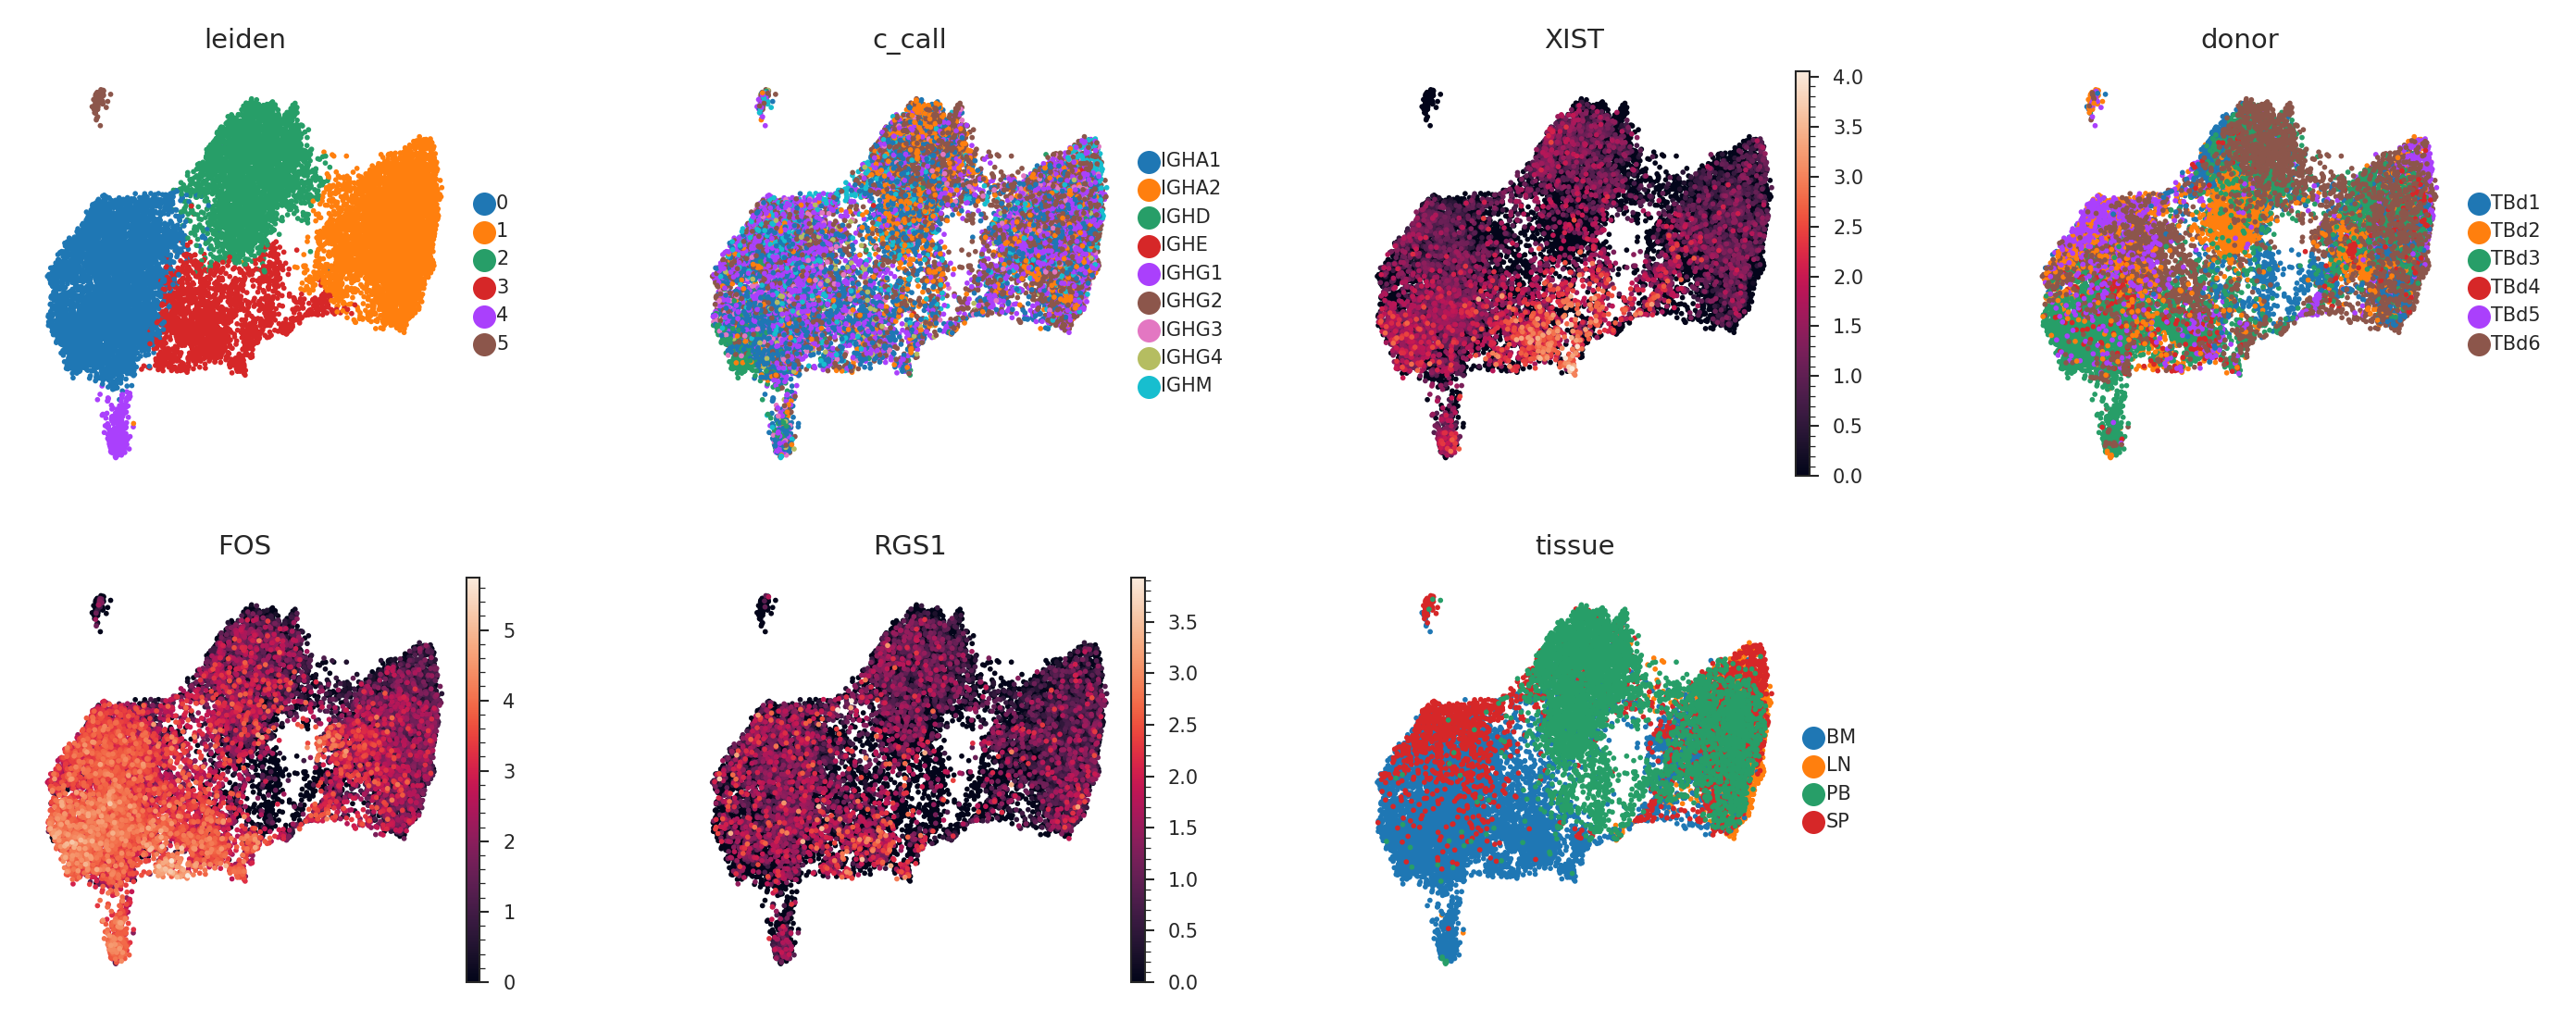

In [9]:
sc.pl.umap(adata, color = ['leiden', 'c_call', 'XIST', 'donor', "FOS", "RGS1", 'tissue'])

## Manually annotate the subtypes


In [10]:

manual = {
    "0": f"{celltype}-1",
    "1": f"{celltype}-3",
    "2": f"{celltype}-3",
    "3": f"{celltype}-2",
    "4": f"{celltype}-1",
    "5": f"{celltype}-4",
    "6": f"{celltype}-1"}
adata.obs["subtype"] = adata.obs.leiden.map(
    lambda x: manual.get(x, f"{celltype}")
)
adata.obs[['subtype']].to_csv("outputs/ASC_subtypes.tab",sep = '\t')

# Generate and Save Figures

In [11]:
# change figure settings for saving figs
sc.set_figure_params(dpi_save=150, frameon=False,
 vector_friendly=True, fontsize=6, figsize=(1,1), format='pdf', transparent=True)

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


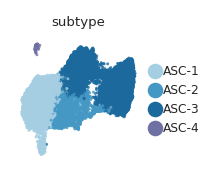

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


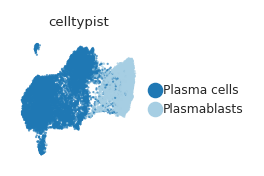

In [12]:
color = "subtype"
sc.pl.umap(adata, color = color, palette = get_asc_colors(), size = 7,
 alpha = 0.8, add_outline=False, save=f"{color}_{celltype}")


color = "celltypist"
sc.pl.umap(adata, color = color, palette = get_bcelltype_colors_alt(), 
size = 4, alpha = 0.7, add_outline=False, save=f"{color}_{celltype}")

## Cell Cycle Regression

In [13]:
# show regression of Cell cycle signature
sc.pp.neighbors(adata, use_rep="scvi_cc_rep", n_neighbors=20, )
sc.tl.umap(
    adata,
    min_dist=0.3,
)

In [14]:
# change figure settings for inset regression figure
sc.set_figure_params(dpi_save=150, frameon=True,
 vector_friendly=True, fontsize=5, figsize=(0.8,0.8), format='pdf', transparent=True)

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


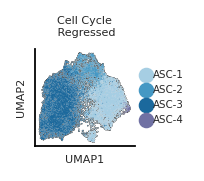

Text(26.000000000000004, 0.5, '')

In [15]:
fig, ax = plt.subplots(1,1, figsize = (0.8,0.8))

color = "subtype"
sc.pl.umap(adata, color = color, palette = get_asc_colors(), size = 0.7, alpha = 0.7, add_outline=True, title = "Cell Cycle\n Regressed", ax = ax)

ax.spines[:].set_visible(True)
ax.legend([])
ax.set_xlabel("")
ax.set_ylabel("")


In [16]:
save_figure(fig, "umap_regressed_w_spines")

## Data Derived Markers

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


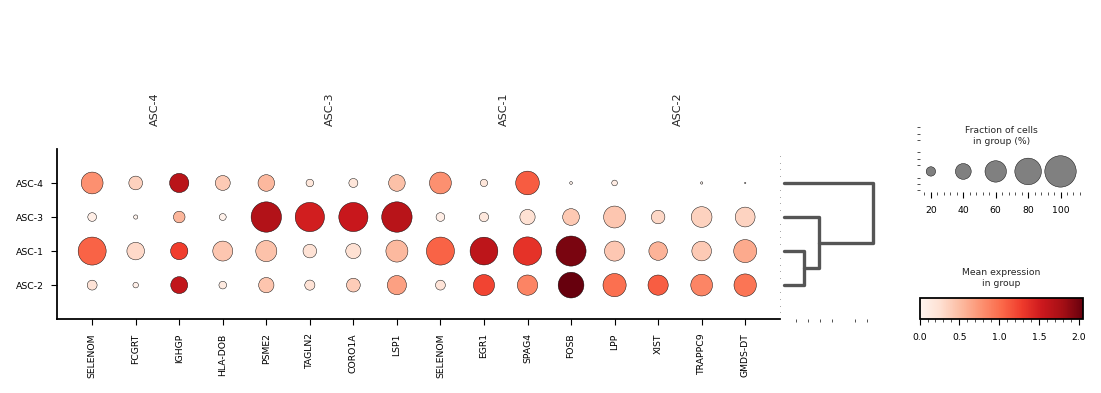

In [17]:
sc.tl.dendrogram(adata, groupby="subtype")
sc.tl.rank_genes_groups(adata, groupby="subtype")
sc.tl.filter_rank_genes_groups(
    adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.6
)
sc.pl.rank_genes_groups_dotplot(
    adata, key="rank_genes_groups_filtered", n_genes=4, save=f"{celltype}_data_derived"
)

In [18]:
# canonical markers
canonical_markers = ['SDC1', 'CD27', 'CD19', "CD38", "MS4A1", "CXCR4", 'MKI67', "HLA-DRB1", "RGS1"]
transcriptional_markers = ["HLA-DOB", "SELENOM", "FCGRT", "LPP", "RASGEF1B", "PSME2", "ARHGDIB"]
markers =  canonical_markers + transcriptional_markers


# Gene Expression Markers for Subtypes

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


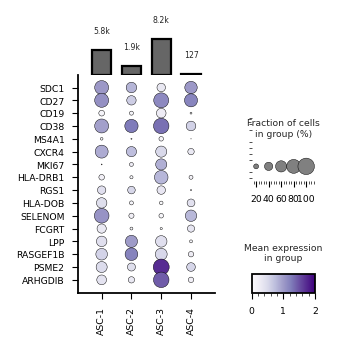

In [19]:
dp = sc.pl.DotPlot(adata, markers, groupby= 'subtype', figsize = (1.9, 2.2), vmax = 2, vmin = 0,  expression_cutoff = 0)
dp.legend(width=0.6)
dp.swap_axes()
dp.add_totals(color = '0.4', size = 0.5).style(dot_edge_color='black', largest_dot = 55 , dot_edge_lw=0.2, cmap = 'Purples').show()

### Tweak Figure

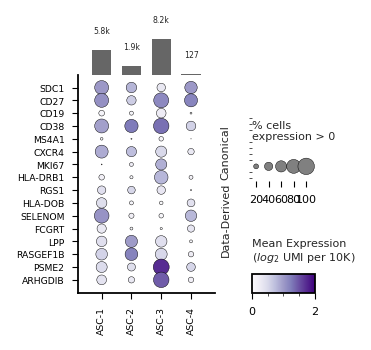

In [20]:
# get axes for tweaking out
#dp.legend(width=0.4)
axes = dp.get_axes()
# First, remove the current title
axes['size_legend_ax'].set_title("")
axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
axes['size_legend_ax'].tick_params(axis='x', labelsize=5)
# Then, create a new title using a text object
title = "% cells\nexpression > 0"
axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)


title = "Mean Expression\n($log_2$ UMI per 10K)"
axes['color_legend_ax'].set_title("")
axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)
axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

#axes['mainplot_ax'].spines[:].set_visible(True)
# Get the bounding box of the main plot
mainplot_box = axes['mainplot_ax'].get_position()
for bar in axes['group_extra_ax'].patches:
    bar.set_edgecolor('none')
ax = axes['mainplot_ax']
# add label
y_text_loc = ax.get_yticks()[(len(canonical_markers) - 2)]
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Canonical', rotation=90)
# add label
y_text_loc = ax.get_yticks()[13]
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Data-Derived', rotation=90)

dp.fig


In [21]:
save_figure(dp.fig, "dotplot_ascs")

# Cell Type Abundances

In [22]:
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')

In [23]:
# Relative Abundances of Plasma Cells in Tissues
def range_ci(x):
    return np.min(x), np.max(x)
df = adata.obs
data = selection_helper(df, "subtype", 20)
data = (
    data.groupby(["donor", "tissue"])
    .subtype.value_counts(normalize=True, )
    .rename("fraction")
    .reset_index()
)
# drop zeroes
data=data[data.fraction > 0]
# drop TICA
data = data[data.donor.str.contains("TBd")]

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


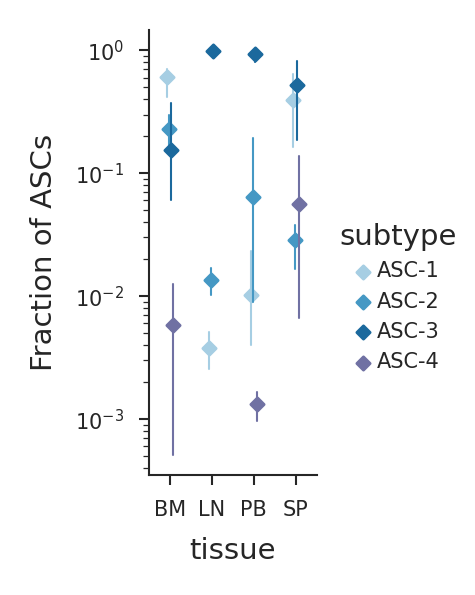

In [24]:
g = sns.catplot(
    data=data,
    x="tissue",
    y="fraction",
    hue="subtype",
    kind = 'point',
    join = False,
    errorbar = range_ci,
    dodge= 0.14,
    palette=get_asc_colors(),
    ax = ax,
    scale = 0.5, errwidth = 0.5, markers = 'D', height = 2, aspect = 0.6
)

g.set(yscale = 'log', ylabel = "Fraction of ASCs")
g.ax.tick_params(axis='x', which = 'minor', length=0)
sns.despine()

In [25]:
save_figure(g.figure, f"{celltype}_subtype_abundances_tissue")

fraction_fig = g.fig

# Isotype Usage of Distinct Subtypes

In [26]:
df = adata.obs

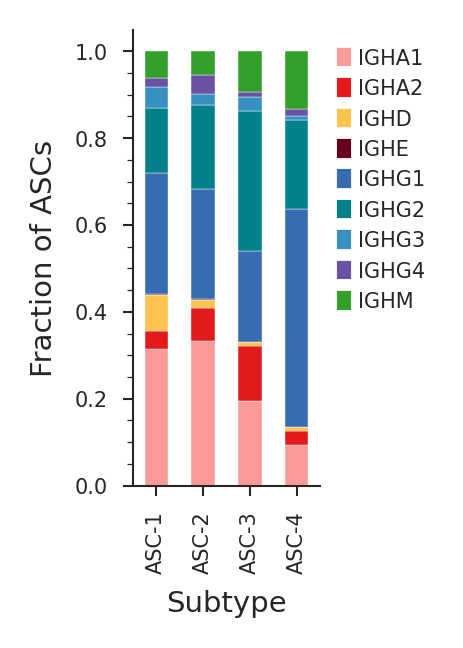

In [27]:
import matplotlib.patches as mpatches
cross_tab = pd.crosstab(df['subtype'], df['c_call'], normalize='index')
fig, ax = plt.subplots(1,1, figsize = (0.8,2))

# Loop over each column (i.e., each stack in the bar)
for i, col in enumerate(cross_tab.columns):
    # Plot this column's data, specify color, add to existing plot (`bottom` parameter)
    cross_tab[col].plot(kind='bar', ax=ax, stacked=True, 
                        color=get_IGH_colors()[col], 
                        bottom = cross_tab.iloc[:, :i].sum(axis=1), linewidth = 0.1)


ax.tick_params(axis='x', which = 'minor', length=0)

# Create a list to store the patches for the legend
patches = []

# Loop over the colors used and create a patch for each
for col in cross_tab.columns:
    patches.append(mpatches.Patch(color=get_IGH_colors()[col], label=col))

# Create the legend

plt.legend(handles=patches, bbox_to_anchor=(1,1))

plt.xlabel('Subtype')
plt.ylabel('Fraction of ASCs')
plt.show()
save_figure(fig, f"stackedbar_{celltype}_c_call")

# Hypermutation levels of distinct subtypes

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_326689/340954842.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


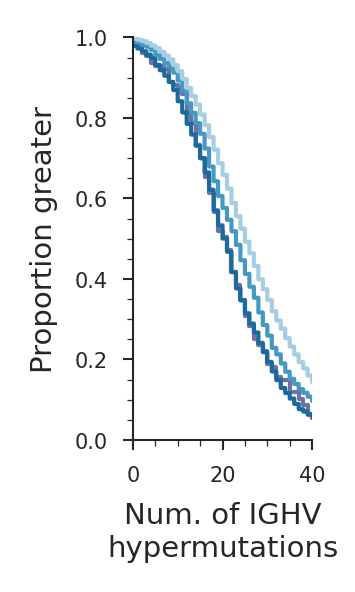

In [28]:
df = adata.obs
g = sns.displot(data = df, x="v_mismatch", hue="subtype", kind = 'ecdf', complementary = True, palette = get_asc_colors(), legend = False, height = 2, aspect = 0.6)
g.set(xlim=(0,40), xlabel = "Num. of IGHV\nhypermutations", ylabel = "Proportion greater") 
plt.tight_layout()

In [29]:
save_figure(g.figure, f"ecdf_{celltype}")

# Differential Expression Between Isotypes Amongst Subtypes of Cells

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


ASC-3


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


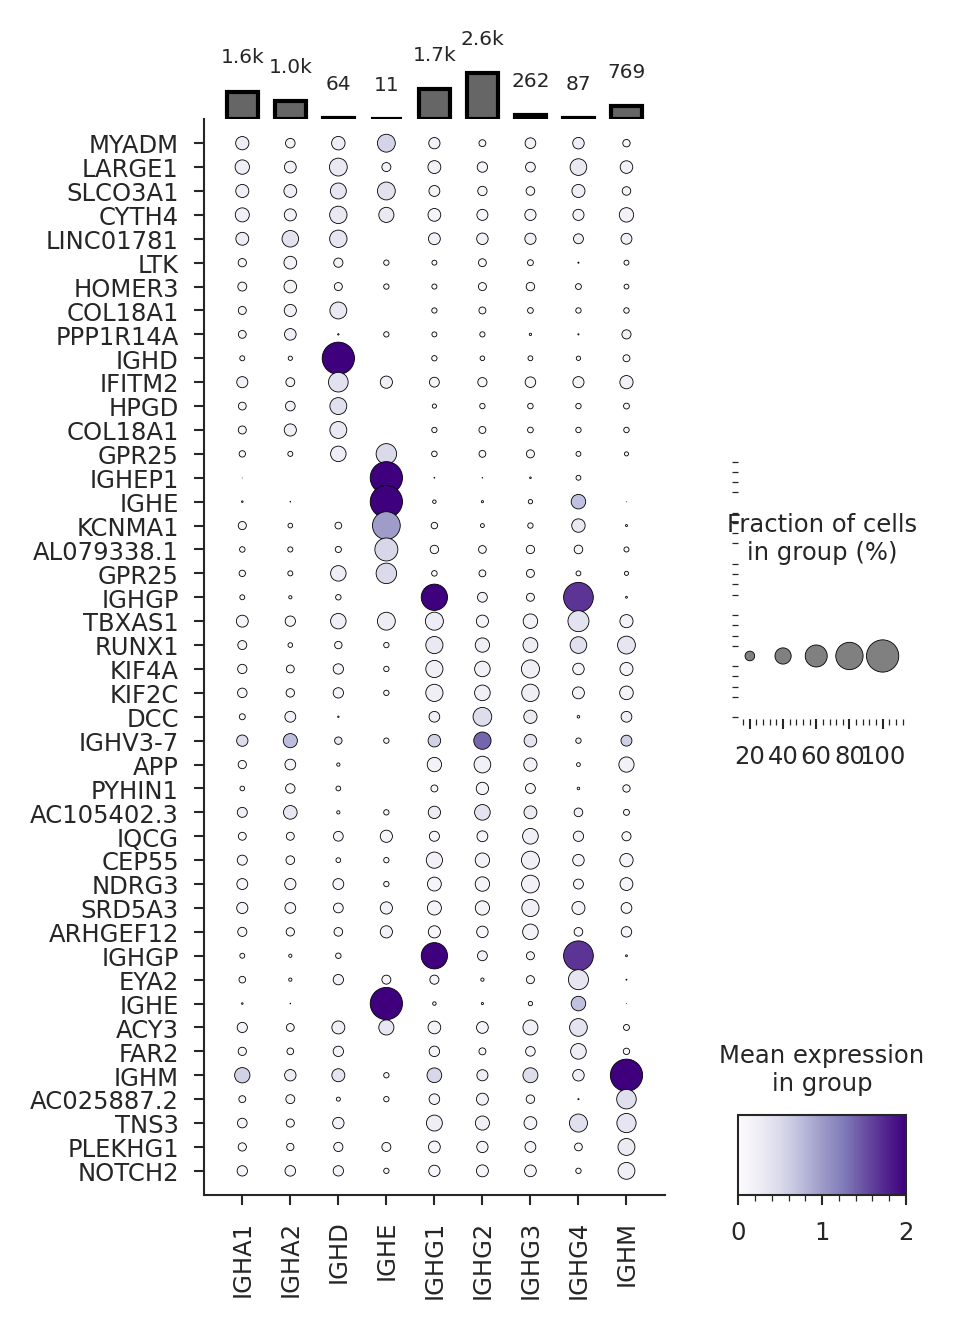

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


ASC-1


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


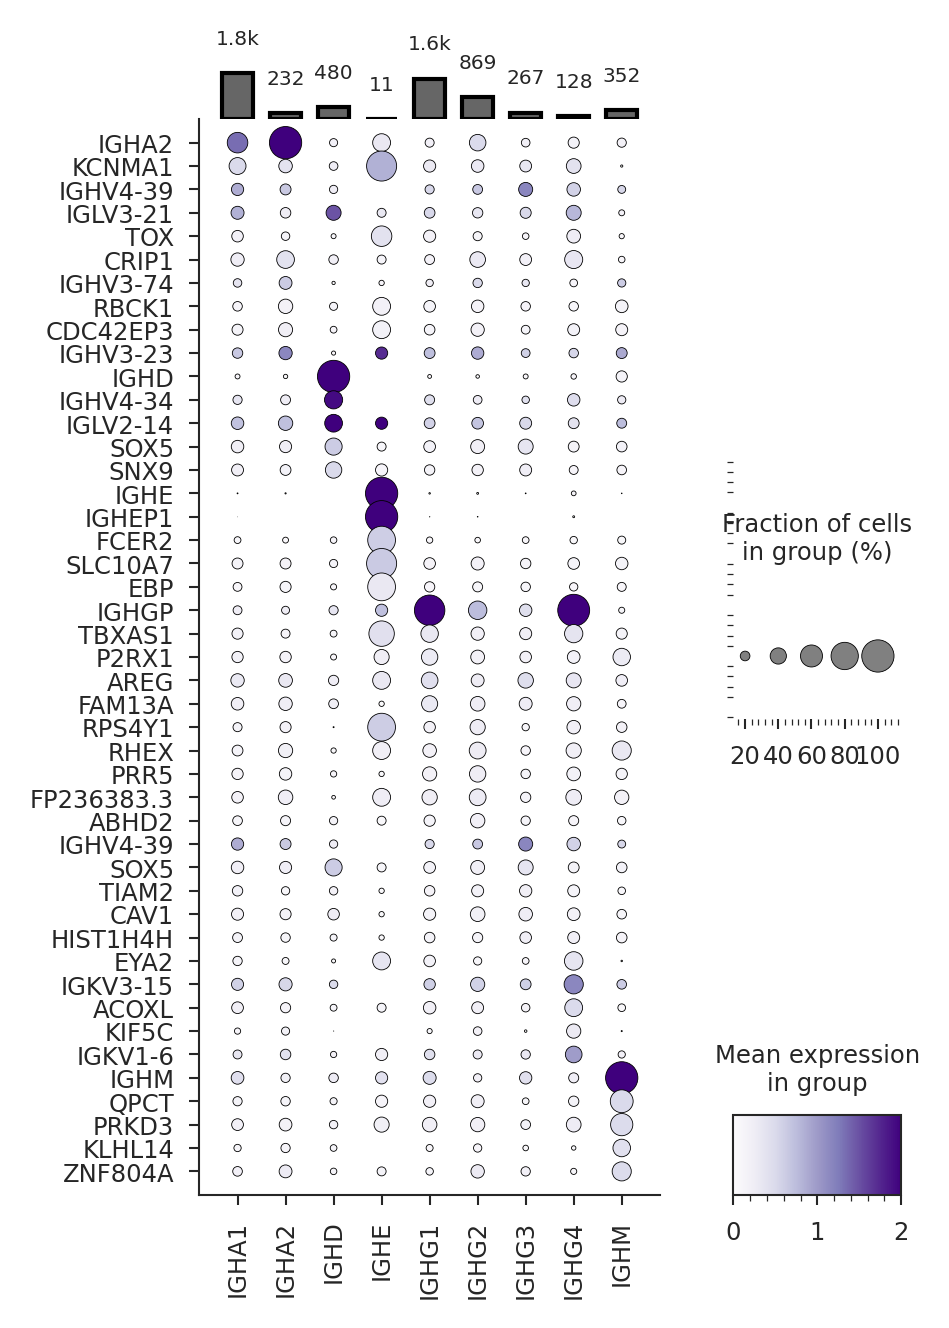

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


ASC-2


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


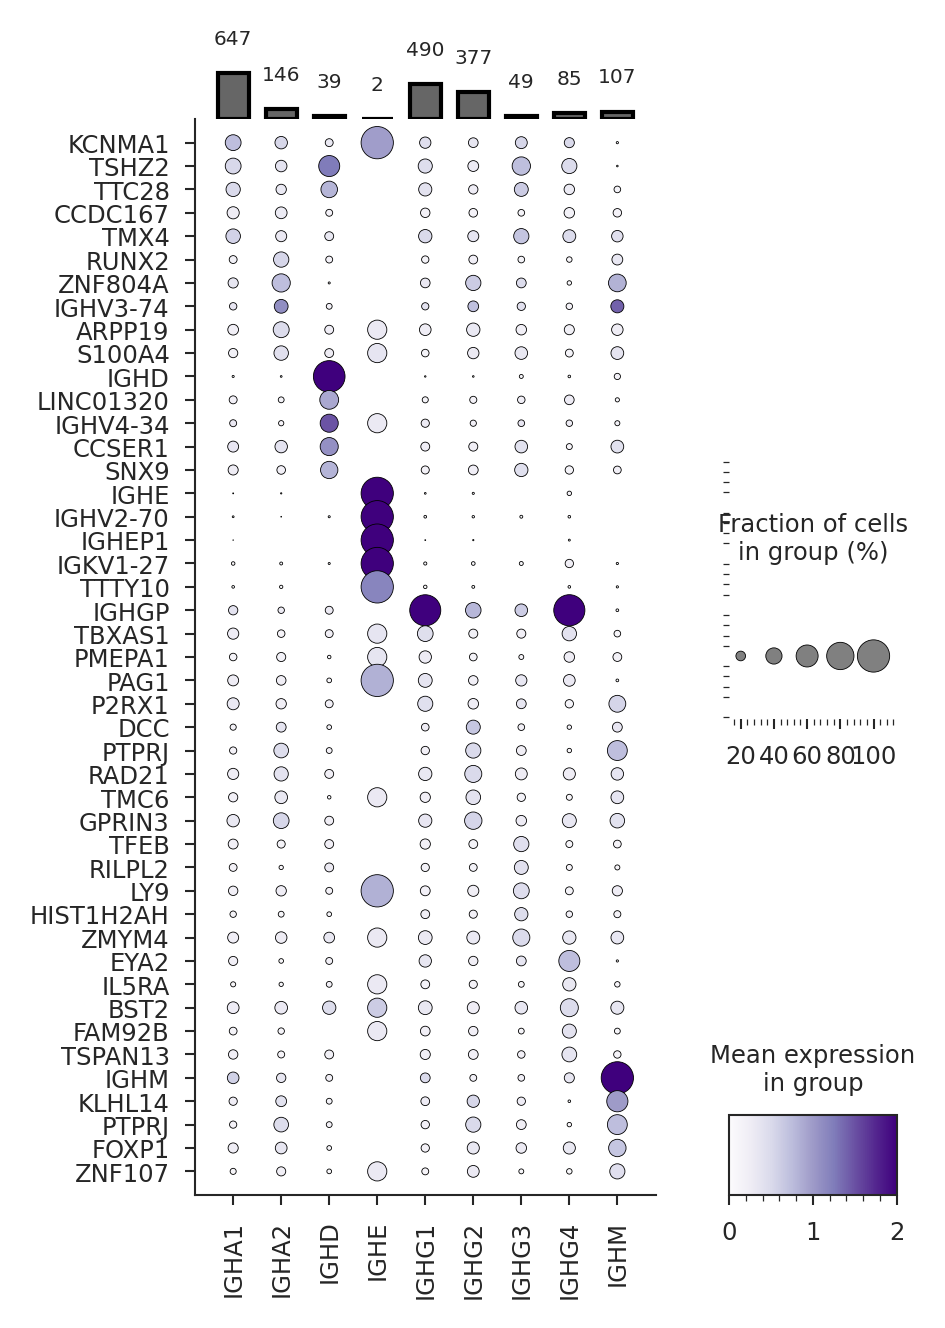

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


not enough samples


In [30]:
subtype_group = 'subtype'
subtypes =  adata.obs[subtype_group].unique()

for subtype in subtypes:    
    sub_adata = adata[adata.obs[subtype_group] == subtype]
    sub_adata.shape
    try:
        sc.tl.rank_genes_groups(sub_adata, groupby=
                        'c_call', method = 'wilcoxon')
        print(subtype)
        sc.tl.filter_rank_genes_groups(sub_adata, max_out_group_fraction=0.3, min_fold_change=0.5)
        # generate list of top 3 genes per category:
        genes_for_dp = []
        array = sub_adata.uns['rank_genes_groups_filtered']['names']
        field_names = list(array.dtype.names)
        for group in field_names:
            genes = sc.get.rank_genes_groups_df(sub_adata, group = group, key = 'rank_genes_groups_filtered').dropna().names[:5].to_list()
            genes_for_dp+=genes
        dp = sc.pl.DotPlot(sub_adata, genes_for_dp, groupby= 'c_call', figsize = (3, 5), vmax = 2, vmin = 0,  expression_cutoff = 0)
        dp.legend(width=0.8)
        dp.swap_axes()
        dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 60 , dot_edge_lw=0.2, cmap = 'Purples').show()
    except ValueError:
        print("not enough samples")
    save_figure(dp.fig, f"isotype_{subtype}_dotplot_ascs")

# Tissue Differential Expression in Subtypes of Cells

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


ASC-3


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


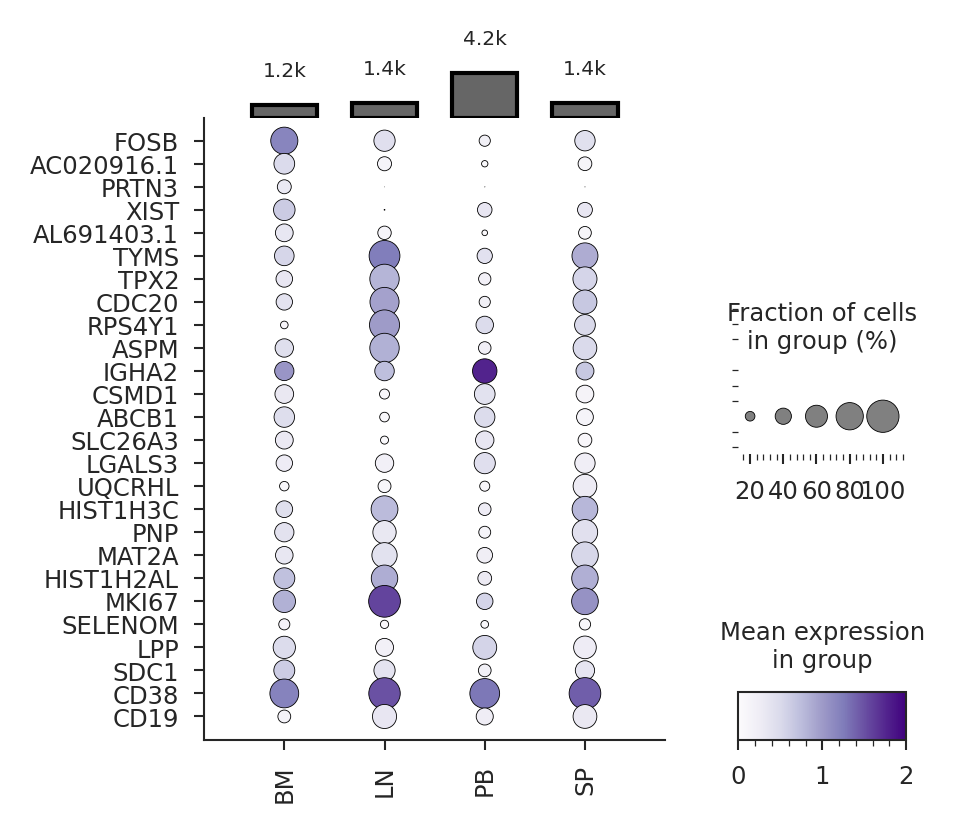

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


ASC-1


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


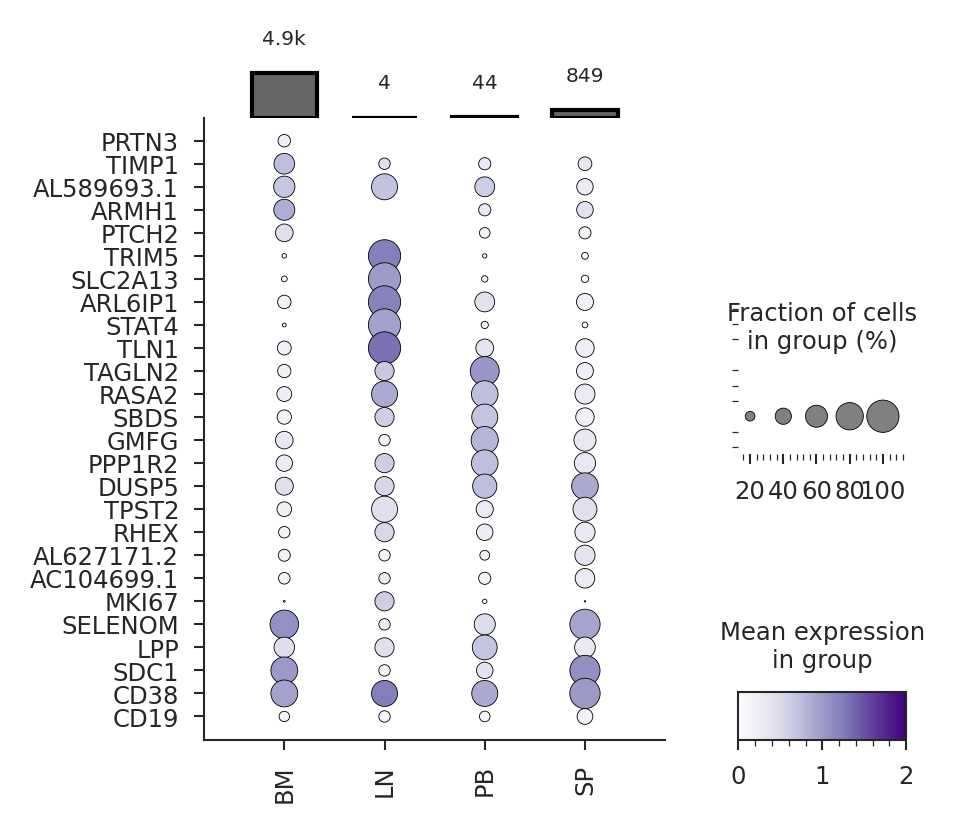

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


ASC-2


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


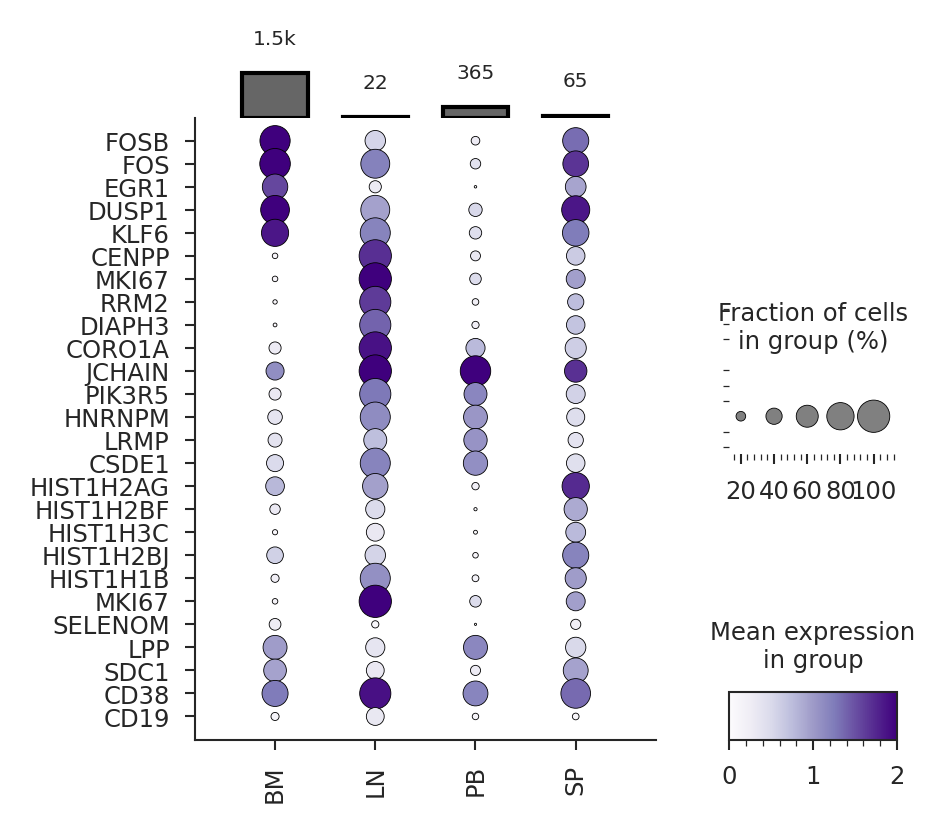

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


ASC-4


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


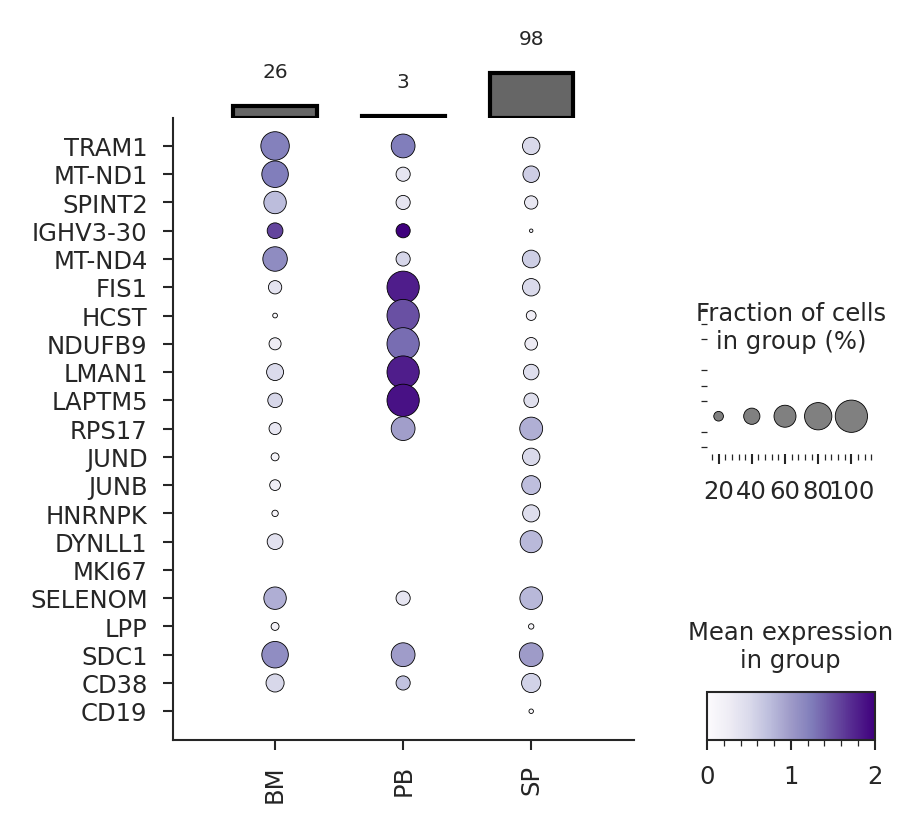

In [31]:
subtype_group = 'subtype'
test_group = 'tissue'
subtypes =  adata.obs[subtype_group].unique()

for subtype in subtypes:    
    sub_adata = adata[adata.obs[subtype_group] == subtype]
    try:
        sc.tl.rank_genes_groups(sub_adata, groupby=
                        test_group, method = 'wilcoxon')
        print(subtype)
        sc.tl.filter_rank_genes_groups(sub_adata, max_out_group_fraction=0.5, min_in_group_fraction=0.2, min_fold_change=1)
        # generate list of top 3 genes per category:
        genes_for_dp = []
        array = sub_adata.uns['rank_genes_groups_filtered']['names']
        field_names = list(array.dtype.names)
        for group in field_names:
            genes = sc.get.rank_genes_groups_df(sub_adata, group = group, key = 'rank_genes_groups_filtered').dropna().names[:5].to_list()
            genes_for_dp+=genes
        dp = sc.pl.DotPlot(sub_adata, genes_for_dp + ['MKI67', 'SELENOM', 'LPP', 'SDC1', 'CD38', 'CD19'], groupby = test_group, figsize = (3, 3), vmax = 2, vmin = 0,  expression_cutoff = 0)
        dp.legend(width=0.8)
        dp.swap_axes()
        dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 60 , dot_edge_lw=0.2, cmap = 'Purples').show()
    except ValueError:
        print("not enough samples")